# Introduction

## Kinteics equations

The set of equations given below calculates deterministicaly the Kinteics of the formation of complexes with two homolouges.

$$\frac{d[AB]}{dt} = k_1[A][B]-k_{-1}[AB]$$

$$\frac{d[AB_i]}{dt} = k_2[A][B_i]-k_{-2}[AB_i]$$

$$\frac{d[A_iB]}{dt} = k_3[A_i][B]-k_{-3}[A_iB]$$

$$\frac{d[A_iB_i]}{dt} = k_4[A_i][B_i]-k_{-4}[A_iB_i]$$

Where $[A]$, $[B]$, $[A_i]$ and $[B_i]$ are instantanious concentrations of the respective reactants and can be caculated using the following relations with  $[A_0]$, $[B_0]$, $[A_{i0}]$ and $[B_{i0}]$ being the starting concentration of the respective reactants.

$$[A]= [A_0]-([AB]-[AB_{0}]+[AB_i]-[AB_{i0}])$$

$$[B]= [B_0]-([A_iB]-[A_iB_{0}]+[AB]-[AB_{0}])$$

$$[A_i]= [A_{i0}]-([A_iB]-[A_iB_{0}]+[A_iB_i]-[A_iB_{i0}])$$

$$[B_i]= [B_{i0}]-([AB_i]-[AB_{i0}]+[A_iB_i]-[A_iB_{i0}])$$

These equations can be solved numericaly to obtain concentrations of every component at different time points.

In [1]:
# use this cell for numba jit ODE solver

import numpy as np
from numba import jit

# @jit 
# def detect_0(x,name):
#     if x == 0:
#         print('Value is 0 for '+name)
            

@jit 
def rate(A_now,B_now,AB,kf,kr): # rate calculator
    return ((kf*(A_now*B_now))-(kr*(AB)))

@jit 
def find_new_AB_RK4(A_now,B_now,AB,kf,kr,dt):
    # rk4 intergrator for a complex works for all complexes
    k1 = rate(A_now,B_now,AB,kf,kr)
    k2 = rate(A_now,B_now,AB+(dt*(k1/2)),kf,kr)
    k3 = rate(A_now,B_now,AB+(dt*(k2/2)),kf,kr)      
    k4 = rate(A_now,B_now,AB+(dt*(k3/2)),kf,kr)
    return (AB+(dt/6)*(k1+(2*k2)+(2*k3)+k4))

@jit 
def find_new_AB_euler(A_now,B_now,AB,kf,kr,dt):
    return AB+(dt*rate(A_now,B_now,AB,kf,kr))

@jit
def Calc_AB_and_more_for_2homols(B0,A0,Bi0,Ai0,AB0,ABi0,AiB0,AiBi0,k1,k_1,k2,k_2,k3,k_3,k4,k_4,max_time,dt):
    # rk4 intergration 
    time_array = np.arange(0,max_time,dt)
    N = len(time_array)
    
    # B,A,Bi,Ai,AB,ABi,AiB,AiBi,rateAB,rateABi,rateAiB,rateAiBi = [B0],[A0],[Bi0],[Ai0],[AB0],[ABi0],[AiB0],[AiBi0],[],[],[],[]
    B,A,Bi,Ai = np.full(N, B0,dtype=np.double),np.full(N, A0 ,dtype=np.double),np.full(N, Bi0 ,dtype=np.double),np.full(N, Ai0 ,dtype=np.double)
    AB,ABi,AiB,AiBi = np.full(N, AB0,dtype=np.double),np.full(N, ABi0 ,dtype=np.double),np.full(N, AiB0 ,dtype=np.double),np.full(N, AiBi0 ,dtype=np.double)
    rateAB,rateABi,rateAiB,rateAiBi = np.zeros(N ,dtype=np.double),np.zeros(N ,dtype=np.double),np.zeros(N ,dtype=np.double),np.zeros(N ,dtype=np.double)
    
    # for each indice except last
    for i in range(1,N):  

        # Caclualting new complex vaules 
        AB[i] = find_new_AB_RK4(A[i-1],B[i-1],AB[i-1],k1,k_1,dt)
        ABi[i] = find_new_AB_RK4(A[i-1],Bi[i-1],ABi[i-1],k2,k_2,dt)
        AiB[i] = find_new_AB_RK4(Ai[i-1],B[i-1],AiB[i-1],k3,k_3,dt)
        AiBi[i] = find_new_AB_RK4(Ai[i-1],Bi[i-1],AiBi[i-1],k4,k_4,dt)
        
        A[i] = A0-AB[i]-ABi[i]
        B[i] = B0-AB[i]-AiB[i]
        Bi[i] = Bi0-ABi[i]-AiBi[i]
        Ai[i] = Ai0-AiB[i]-AiBi[i] 
        
        # Checking 0 values
        # detect_0(AB[i],'AB')
        # detect_0(ABi[i],'ABi')
        # # detect_0(AiB[i],'AiB')
        # # detect_0(AiBi[i],'AiBi')
        # detect_0(A[i],'A')
        # detect_0(B[i],'B')
        # detect_0(Bi[i],'Bi')
        # detect_0(Ai[i],'Ai')          
        
        # updating rate. this is just for log
        rateAB[i] = rate(A[i-1],B[i-1],AB[i-1],k1,k_1)
        rateABi[i] = rate(A[i-1],Bi[i-1],ABi[i-1],k2,k_2)
        rateAiB[i] = rate(Ai[i-1],B[i-1],AiB[i-1],k3,k_3)
        rateAiBi[i] = rate(Ai[i-1],Bi[i-1],AiBi[i-1],k4,k_4)
        
        # detect_0(rateAB[i],'rateAB')
        # detect_0(rateAB[i],'rateAB')
        
    return B,A,Bi,Ai,AB,ABi,AiB,AiBi,rateAB,rateABi,rateAiB,rateAiBi,time_array

## Example simulation

In [2]:
# Common stuff
# starting concentrations
B0 = 1
A0 = 1
Bi0 = 2
Ai0 = 0
AB0 = 0
ABi0 = 0
AiB0 = 0
AiBi0 = 0
# rate constants 
k1,k_1 =  1,1e-6
k2,k_2 =  1,1e-1
k3,k_3 =  0,0
k4,k_4 =  0,0

# time limit
max_time = 100

# time step 
dt = 0.001

# solve
B,A,Bi,Ai,AB,ABi,AiB,AiBi,rateAB,rateABi,rateAiB,rateAiBi,time_array=Calc_AB_and_more_for_2homols(B0,A0,Bi0,Ai0,AB0,ABi0,AiB0,AiBi0,k1,k_1,k2,k_2,k3,k_3,k4,k_4,max_time,dt)

Text(0, 0.5, 'Concentration(M)')

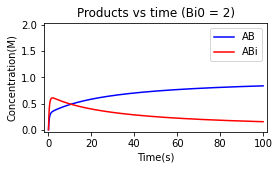

In [3]:
# plotting with matplotlib

import matplotlib.pyplot as plt

# intitate figure
plt.figure(figsize=(4,2))

# x and y axis limits
xcrop = 100
ycrop = 2
plt.xlim(-1*(xcrop/50),xcrop+1*(xcrop/50))
plt.ylim(-1*(ycrop/50),ycrop+1*(ycrop/50))

# title
title = 'Products vs time'
plt.title(title+' (Bi0 = '+str(Bi0)+')')

# plt.plot(time_array,A[:-1],label='A',c='blue')
# plt.plot(time_array,B[:-1],label='B')
# plt.plot(time_array,Bi[:-1],label='Bi')
# plt.plot(time_array,Ai[:-1],label='Ai')

# plotting products
plt.plot(time_array,AB,label='AB',c='Blue')
plt.plot(time_array,ABi,label='ABi',c='Red')
# plt.plot(time_array,AiB[:-1],label='AiB')
# plt.plot(time_array,AiBi[:-1],label='AiBi')

# Adding legends
plt.legend(loc=1)
plt.xlabel('Time(s)')
plt.ylabel('Concentration(M)')